## Libraries and Imports

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from llms.exin_classifier.gpt import ExInClassifierGPT
from schemas.train_params import TrainParams

## Params and Files

In [3]:
seed = 42

csv_path = "exin-512.csv"
pretrained_model_name = "ExInGPT"

In [4]:
csv_path = f"./storage/data/processed/{csv_path}"
output_path = f"./storage/models/tuned/{pretrained_model_name}"
checkpoint = f"./storage/models/base/gpt2"

## Reading Dataset

In [5]:
df = pd.read_csv(csv_path, keep_default_na=False)

## Loading the Model

In [6]:
llm = ExInClassifierGPT(
  checkpoint=checkpoint,
  seed=seed
)

## Data Processing

In [7]:
data = df.to_dict(orient="records")

In [8]:
all_dataset = []
for record in tqdm(data):
	example = llm.build_input(
		sequence=record["sequence"],
		target=record.get("target"),
		organism=record.get("organism"),
		gene=record.get("gene"),
		before=record.get("before"),
		after=record.get("after")
	)
	all_dataset.append(example)

train_dataset, test_dataset = train_test_split(
	all_dataset,
	test_size=0.05,
	random_state=seed,
	shuffle=True
)

  0%|          | 0/7876655 [00:00<?, ?it/s]

100%|██████████| 7876655/7876655 [00:05<00:00, 1502980.87it/s]


# Data Analysis

In [9]:
print("Train Dataset Len:", len(train_dataset))
print("Test Dataset Len:", len(test_dataset))

Train Dataset Len: 7482822
Test Dataset Len: 393833


In [10]:
train_lengths = [len(example["sequence"]) for example in train_dataset]
test_lengths = [len(example["sequence"]) for example in test_dataset]

Train Dataset Len: 7482822
Test Dataset Len: 393833


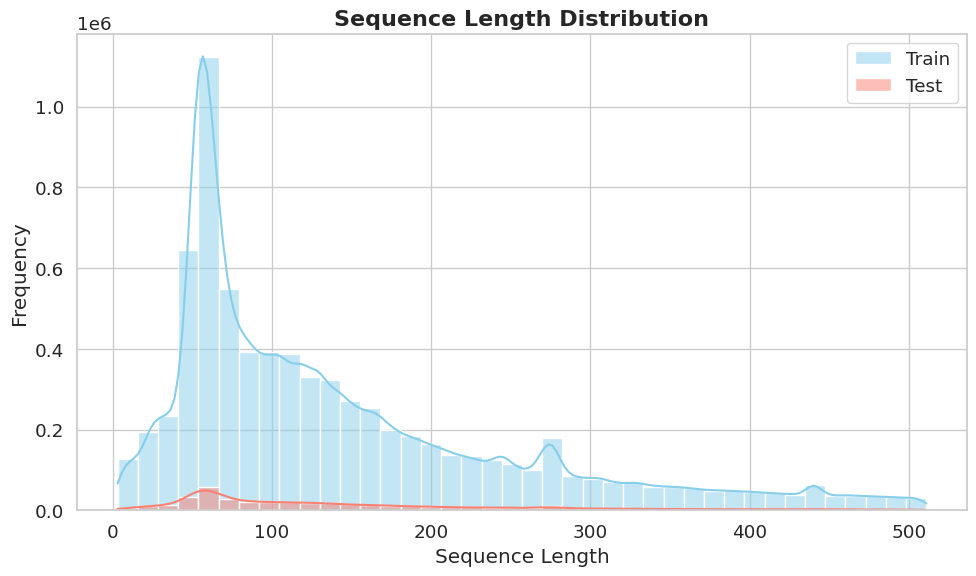

In [11]:
print("Train Dataset Len:", len(train_dataset))
print("Test Dataset Len:", len(test_dataset))

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.histplot(train_lengths, kde=True, bins=40, color="skyblue", label="Train")
sns.histplot(test_lengths, kde=True, bins=40, color="salmon", label="Test")

plt.title("Sequence Length Distribution", fontsize=16, weight="bold")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

## Training

In [10]:
llm.train(
  dataset=train_dataset,
  params=TrainParams(
    epochs=1,
    batch_size=1,
    gradient_accumulation=1,
    lr=2e-5,
    logging_steps=25000
	)
)

2025-10-13 13:49:17,897 - INFO - Preparing dataset...
100%|██████████| 7482822/7482822 [1:45:21<00:00, 1183.71it/s] 
2025-10-13 15:41:40,943 - INFO - Dataset prepared!
2025-10-13 15:41:56,564 - INFO - Starting training...
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
25000,0.459600
50000,0.125400
75000,0.094800
100000,0.091700
125000,0.086300
150000,0.080300
175000,0.073700
200000,0.068700
225000,0.066900
250000,0.069200


2025-10-15 18:58:48,215 - INFO - Training complete. You may save the model for later use.


# Saving The Model

In [11]:
llm.save_pretrained(output_path)

2025-10-15 18:58:49,023 - INFO - Attempting to save model at './storage/models/tuned/ExInGPTModel'
2025-10-15 18:58:53,735 - INFO - Successfully saved at './storage/models/tuned/ExInGPTModel'


# Test

In [12]:
y_true = []
y_pred = []

for data in tqdm(test_dataset):
	answer = llm.generate(data)
	y_pred.append(answer)
	y_true.append(data["target"])

100%|██████████| 393833/393833 [51:04<00:00, 128.50it/s]


In [13]:
print("INTRON class:")
print("  Precision :", precision_score(y_true, y_pred, pos_label="INTRON"))
print("  Recall    :", recall_score(y_true, y_pred, pos_label="INTRON"))
print("  F1        :", f1_score(y_true, y_pred, pos_label="INTRON"))
print()
print("EXON class:")
print("  Precision :", precision_score(y_true, y_pred, pos_label="EXON"))
print("  Recall    :", recall_score(y_true, y_pred, pos_label="EXON"))
print("  F1        :", f1_score(y_true, y_pred, pos_label="EXON"))
print()
print("  Accuracy  :", accuracy_score(y_true, y_pred))

INTRON class:
  Precision : 0.9977726377109569
  Recall    : 0.9973795985476468
  F1        : 0.9975760794155182

EXON class:
  Precision : 0.9988957174768949
  Recall    : 0.999061564948729
  F1        : 0.9989786343294356

  Accuracy  : 0.9985628426261892
